In [30]:
from hcipy import *
from hcipy import atmosphere
from hcipy import fourier
import numpy as np
from matplotlib import pyplot as plt

# For notebook animations
from matplotlib import animation
from IPython.display import HTML

## sim foucault knife edge

In [1]:
pupil_grid = make_pupil_grid(1024)
focal_grid = make_focal_grid(32, 8) # pixels per resolution, spatial extent of grid

prop = FraunhoferPropagator(pupil_grid, focal_grid)
prop2 = FraunhoferPropagator(focal_grid, pupil_grid)

NameError: name 'make_pupil_grid' is not defined

In [ ]:
zmodes = make_zernike_basis(20, 1, pupil_grid, 2)
dm = DeformableMirror(zmodes)

In [ ]:
#apertures

#pupil plane:
aperture = make_circular_aperture(1)
aperture = evaluate_supersampled(aperture, pupil_grid, 8)

# focal plane
rec_ap = make_rectangular_aperture(32, (0, 16))
rec_ap = evaluate_supersampled(rec_ap, focal_grid, 8)

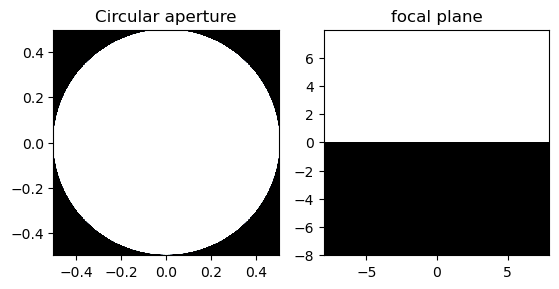

In [191]:
#showing the Reference
plt.subplot(1,2,1)
plt.title("Circular aperture")
imshow_field(aperture, cmap = 'bone')
plt.subplot(1,2,2)
plt.title("focal plane")
imshow_field(rec_ap, cmap = 'bone')
plt.show()

In [192]:
coro = KnifeEdgeLyotCoronagraph(pupil_grid, q=8, direction='+x', apodizer=None, lyot_stop=None)
wf = Wavefront(aperture)
img_ref = prop(wf).intensity
lyot_plane = coro(wf)

In [193]:
# adding aberration to wavefront
angular_separations = np.linspace(-5, 5, 51)
wf = Wavefront(aperture* np.exp(2j * np.pi * pupil_grid.x * angular_separations[40]))
lyot_plane = coro(wf)

In [229]:
# OR propagate through a DM zernike
dm.flatten()
dm.actuators[0] = 0.1
wf = Wavefront(aperture)
wf_dm = dm(wf)
lyot_plane = coro(wf_dm)
img = prop(wf_dm)

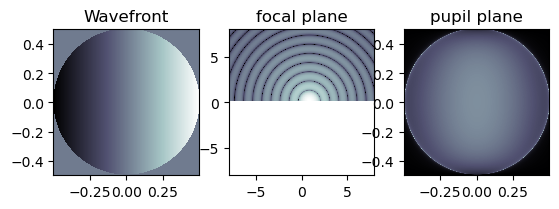

In [230]:
# Plots: wf, pupil, lyot

plt.subplot(1,3,1)
plt.title("Wavefront")
imshow_field(wf_dm.phase*aperture, cmap = 'bone')

plt.subplot(1,3,2)
plt.title("focal plane")
imshow_field(np.log10(img.intensity / img_ref.max())*rec_ap,vmin=-8, vmax=0,  cmap = 'bone')

plt.subplot(1,3,3)
plt.title("pupil plane")
imshow_field((lyot_plane.intensity), vmin=0, vmax=2,cmap = 'bone')
plt.show()

### other knife edge tests

/tmp/ipykernel_999426/3960338318.py:1: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  lyot_stop = Apodizer(circular_aperture(0.99)(pupil_grid))


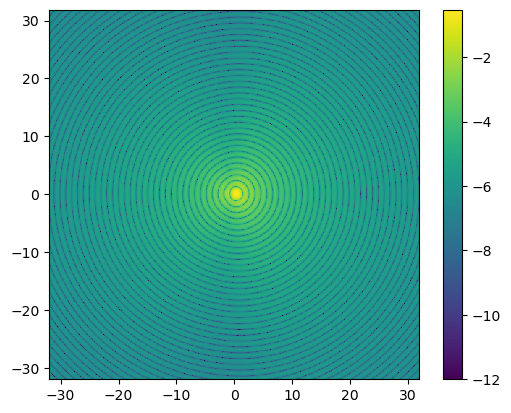

In [27]:
lyot_stop = Apodizer(circular_aperture(0.99)(pupil_grid))

img = prop(lyot_stop(lyot))
img_ref = prop(wf).intensity

imshow_field(np.log10(img.intensity / img_ref.max()), vmin=-12)
plt.colorbar()
plt.show()



In [31]:
def create_offaxis_animation(coro):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Lyot plane')
    im1 = imshow_field(lyot_plane.intensity, vmax=1, cmap='inferno')
    plt.subplot(1,2,2)
    plt.title('Science image plane')
    im2 = imshow_field(np.log10(img.intensity / img_ref.max()), vmin=-5, vmax=0, cmap='inferno')
    plt.close(fig)

    def animate(angular_separation):
        wf = Wavefront(aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation))
        lyot = coro(wf)
        img = prop(lyot_stop(lyot))

        im1.set_data(*pupil_grid.separated_coords, lyot.intensity.shaped)
        im2.set_data(*focal_grid.separated_coords, np.log10(img.intensity.shaped / img_ref.max()))

        return [im1, im2]

    angular_separations = np.linspace(-5, 5, 51)
    anim = animation.FuncAnimation(fig, animate, angular_separations, interval=160, blit=True)
    return HTML(anim.to_html5_video())

create_offaxis_animation(coro)

## Test PyWFS

Stealing and modifying this from og_sim and modifying it for quals

In [98]:
import sim_sparkle as smsp
#reload(smsp)

In [107]:
wavelength = 800.0e-9
Dtel = 6.5
Dgrid = 60/56 * Dtel
n_bin = 2 #this allows us to oversample our pupil
pupil_grid = make_pupil_grid(60*n_bin, Dgrid)
pwfs_grid = make_pupil_grid(120*n_bin, 2 * Dgrid)

In [132]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=Dgrid, pupil_diameter=Dtel, wavelength_0=wavelength, q=4) # q gives pixels per lambda over D
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3 * wavelength/Dtel, num_steps=20) #, fast_modulation_method=True) # had to exlude bc not on sebastiaans version

In [134]:
magellan_aperture = evaluate_supersampled(make_magellan_aperture(), pupil_grid, 8)
zmodes = make_zernike_basis(200, Dtel, pupil_grid, 2)
dm = DeformableMirror(zmodes)

In [135]:
# Illumination reference
Iref = 0
for wfi in mpwfs(wf):
	Iref += wfi.power
Iref /= 20
Iref_bin = subsample_field(Iref, n_bin)

In [136]:
#### SLOPES 
# Right now, working without regularizations
# Slopes are an tranversed slopes

calibration_amplitude = 10e-9
dm.flatten()

zern_slopes = []
for i in range(dm.num_actuators):
	if i % 10 == 0:
		print("Calibrating mode {:d}".format(i))

	slope = 0
	for s in [-1, 1]:
		dm.actuators[i] += s * calibration_amplitude

		im = 0		
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /=20
		im_binned = subsample_field(im, n_bin)

		slope += s * im_binned / (2 * calibration_amplitude)

		dm.actuators[i] -= s * calibration_amplitude
	zern_slopes.append(slope)
# slopes to use, tranverse of images
zern_slopes = np.array(zern_slopes).T
# reconstruction matrix from inverse tikhonov
zern_ret_mat = inverse_tikhonov(zern_slopes,1e-3)

Calibrating mode 0


Calibrating mode 10
Calibrating mode 20
Calibrating mode 30
Calibrating mode 40
Calibrating mode 50
Calibrating mode 60
Calibrating mode 70
Calibrating mode 80
Calibrating mode 90
Calibrating mode 100
Calibrating mode 110
Calibrating mode 120
Calibrating mode 130
Calibrating mode 140
Calibrating mode 150
Calibrating mode 160
Calibrating mode 170
Calibrating mode 180
Calibrating mode 190


In [139]:
# what I want to do: for each apmplitude of aberration, show what the reconstructor sees in the pupil plane
# test parameters:
num_steps = 20
amps_test = np.linspace(0, 800e-9, num_steps)
mode = 2 # only working on tip to start
coeff_test = np.zeros(amps_test.size) #coeffs without additional aberrations

#create the unaberrated wavefront
prop, norm, focal_grid = smsp.init_prop(pupil_grid, wf, n_airy=28)

wf = smsp.create_wf(magellan_aperture)
wf_zern = dm.forward(wf)
PSF = prop(dm(wf)).power

#going to animate this
def test_pupil_animation():
    # set up plotting
    fig = plt.figure(figsize=(16,3))
    # SENT ABERRATION
    plt.subplot(1,4,1)
    plt.title(r'DM wavefront (waves)')
    im1 = imshow_field(wf_zern.phase, pupil_grid, cmap='bone')
    plt.colorbar()
    # RECONSTRUCTED ABERRATION
    plt.subplot(1,4,2)
    plt.title(r'PyWFS surface (%)')
    im2 = imshow_field(Iref_bin/Iref_bin.max(), vmin=-1.5, vmax=1.5, cmap='bwr')
    plt.colorbar()
    #PSF response
    plt.subplot(1,4,3)
    plt.title('Focal plane')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    plt.colorbar()
    # Reconstruction curve
    plt.subplot(1,4,4)
    plt.title('Reconstruction')
    line, = plt.plot(amps_test, coeff_test, color='k')
    #from the animationcode
    plt.close(fig)

    def animate(t): 
        ai = t
        amp = amps_test[t]
        # cear and set dm
        dm.flatten()
        dm.actuators[mode] = amp # rms put in get twice back SURFACE
        # propagate through the AO system
        wf_zern = dm.forward(wf)
        phase = wf_zern.phase
        wf_pyr = mpwfs.forward(wf_zern)
        psf = prop(wf_zern).power
        # printing 
        im = 0		
        for wfi in mpwfs(dm(wf)):
            im += wfi.power
        im /= 20
        im_binned = subsample_field(im, n_bin)
        # difference between what we have and what we expect
        wfs_image = im_binned 
        diff_image = wfs_image - Iref_bin
        
        # Use Coeffs on the reconstruction to see differences
        coeffs = zern_ret_mat.dot(diff_image)
        dm.actuators = coeffs
        # adding to the 
        coeff_test[ai] = coeffs[mode]
        #SETTING PLOTs
        #print(wfs_image.shaped.shape)
        #print(zern_dm.surface.shaped.shape)
        #print(psf.shaped.shape)
        im1.set_data(*phase.grid.separated_coords, (phase*magellan_aperture).shaped)
        im2.set_data(*diff_image.grid.separated_coords, diff_image.shaped/Iref_bin.max())
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))
        line.set_data(amps_test[:ai], coeff_test[:ai])
        line.axes.axis([0, 8e-7, 0, 8e-7])

        return [im1, im2, im3, line]
    
    time_steps = np.arange(num_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    anim.save('test.gif')
    return HTML(anim.to_jshtml(default_mode='loop'))

test_pupil_animation()
